#IMPORT NECESSARY LIBRARIES

In [1]:
# !pip install torchsummary
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
# !pip install timm
# !pip install torchinfo

In [2]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3219109/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
import torch.hub
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.distributed import DistributedSampler
import torch.multiprocessing as mp
# from torchsummary import summary
from torchinfo import summary
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v05/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from efficientnet_pytorch import EfficientNet

##Define runtime

In [6]:
# !pip install ipython-autotime
%load_ext autotime

time: 221 µs (started: 2024-09-05 05:45:57 -04:00)


##Define GPU usage

In [7]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 169 ms (started: 2024-09-05 05:45:57 -04:00)


In [8]:
# Set the GPU device
gpu_index = 0  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 0: Tesla K80
time: 2.31 ms (started: 2024-09-05 05:45:57 -04:00)


#DATA PREPARATION

##Get and Import dataset

In [9]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 3.49 ms (started: 2024-09-05 05:45:57 -04:00)


###Meta-data

In [10]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 73.2 ms (started: 2024-09-05 05:45:57 -04:00)


In [11]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 50.5 ms (started: 2024-09-05 05:45:57 -04:00)


In [12]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 21.8 ms (started: 2024-09-05 05:45:57 -04:00)


###Meta-data information

In [13]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 11.9 ms (started: 2024-09-05 05:45:57 -04:00)


In [14]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 8.37 ms (started: 2024-09-05 05:45:57 -04:00)


In [15]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 6.69 ms (started: 2024-09-05 05:45:57 -04:00)


##DATA PREPROCESSING

###Original data information

In [16]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 12.5 ms (started: 2024-09-05 05:45:57 -04:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [17]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 48.8 ms (started: 2024-09-05 05:45:57 -04:00)


In [18]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 34.9 ms (started: 2024-09-05 05:45:57 -04:00)


In [19]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 24.5 ms (started: 2024-09-05 05:45:57 -04:00)


###Get images data

finish preprocessing

In [20]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...


time: 11.3 s (started: 2024-09-05 05:45:57 -04:00)


In [21]:
# train_metadata_pp = train_metadata_pp.sample(n=2000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 16.5 ms (started: 2024-09-05 05:46:09 -04:00)


###Correctting image paths

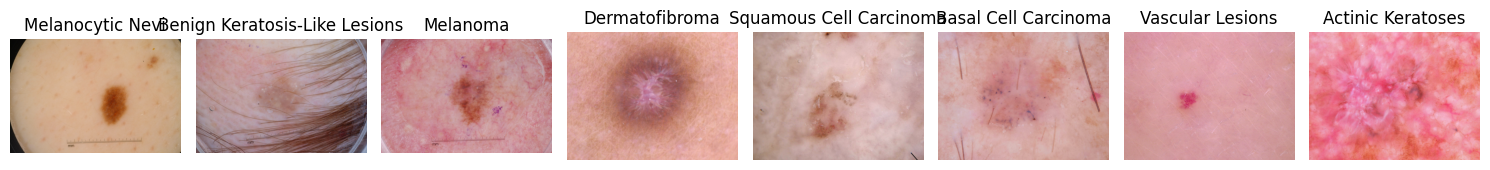

time: 28 s (started: 2024-09-05 05:46:09 -04:00)


In [22]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [23]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 6.73 ms (started: 2024-09-05 05:46:37 -04:00)


###Augment and transfrom dataset

In [24]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 299x299
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 17.9 ms (started: 2024-09-05 05:46:37 -04:00)


###Split data

In [25]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 23.4 ms (started: 2024-09-05 05:46:37 -04:00)


###Balancing dataset

In [26]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 63.4 ms (started: 2024-09-05 05:46:37 -04:00)


In [27]:
# # Separate features and labels for balancing
# X_train = train_df.drop(columns=['Diagnosis_Label'])
# y_train = train_df['Diagnosis_Label']

# # Combine resampled features and labels into a DataFrame
# train_df_resampled = X_train
# train_df_resampled['Diagnosis_Label'] = y_train

# print(f"Resampled training set size: {len(train_df_resampled)}")

time: 377 µs (started: 2024-09-05 05:46:37 -04:00)


###Load dataset

In [28]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

# Modify DataLoader to use DistributedSampler
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8,
                          persistent_workers=True,
                          pin_memory=True
                         )
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8,
                        persistent_workers=True,
                        pin_memory=True
                       )
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8,
                         persistent_workers=True,
                         pin_memory=True
                        )

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([3, 5, 6, 6, 7, 1, 1, 6, 1, 7, 4, 6, 0, 2, 3, 5, 7, 5, 6, 1, 3, 7, 7, 5,
        1, 3, 2, 2, 6, 5, 6, 7])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 5.78 s (started: 2024-09-05 05:46:37 -04:00)


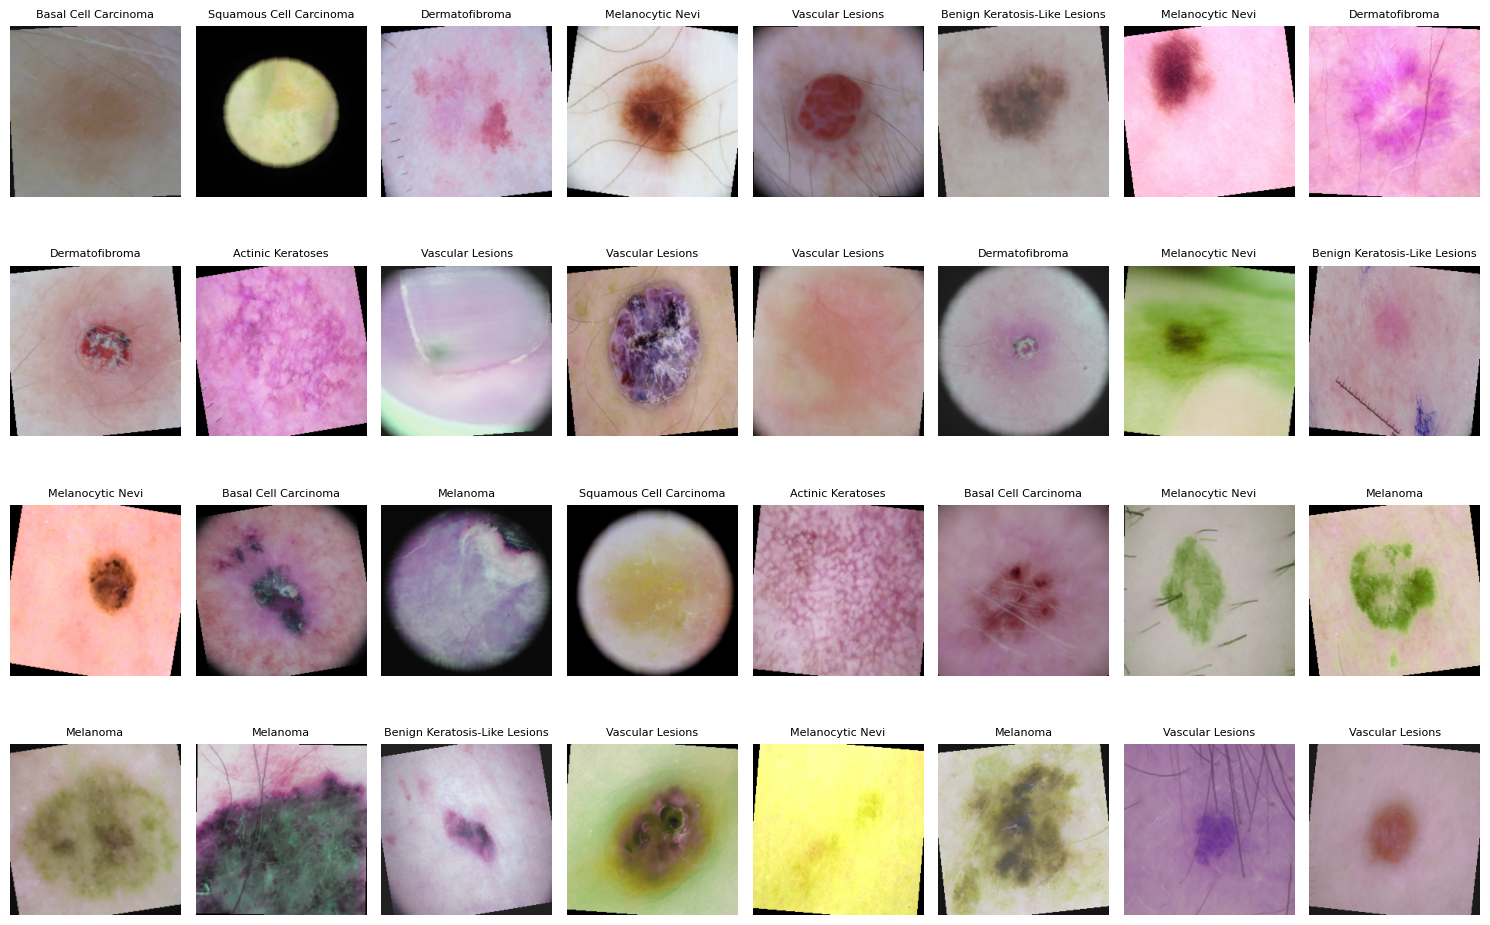

time: 6.33 s (started: 2024-09-05 05:46:43 -04:00)


In [29]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Prepare test data for ensemble model predictions

###Load pre-trained and construct models

###Original data information

In [ ]:
test_metadata.info()
print()
test_metadata
# print(test_metadata.columns)

###Data cleansing

In [ ]:
# Removing duplicate rows
test_metadata_pp = test_metadata.drop_duplicates()

# Removing rows with missing values
test_metadata_pp = test_metadata_pp.dropna()

# Fixing column names
test_metadata_pp = test_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'sex': 'Sex'
})

# Replace missing values in 'age' column with median age
median_age = test_metadata_pp['Age'].median()
test_metadata_pp['Age'] = test_metadata_pp['Age'].fillna(median_age)

# Convert the Age column to integers
test_metadata_pp['Age'] = test_metadata_pp['Age'].astype(int)

# Add a placeholder Diagnosis column
test_metadata_pp['Diagnosis'] = 'Unknown'

test_metadata_pp.info()
print()
test_metadata_pp

###Get images data

finish preprocessing

In [ ]:
# Load test images
test_image_paths = [os.path.join(test_input_dir, fname) for fname in os.listdir(test_input_dir)]
test_image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in test_image_paths}
test_metadata_pp['Image_path'] = test_metadata_pp['Image_Id'].map(test_image_path_dict)

test_metadata_pp.info()
print()
test_metadata_pp

###Load test data

In [ ]:
# Use test_metadata
class LoadedTestDatasetToPredict(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = self.dataframe.iloc[idx]['Diagnosis_Label']
            return image, label

In [ ]:
# Define the transformation for the test dataset
prediction_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Create the test dataset
# prediction_test_dataset = LoadedTestDatasetToPredict(test_metadata_pp, transform=prediction_test_transform, is_test=True)
prediction_test_dataset = LoadedTestDatasetToPredict(test_metadata_pp, transform=None, is_test=True)

# Create the test dataloader
prediction_test_loader = DataLoader(prediction_test_dataset, batch_size=32, shuffle=False, num_workers=4)

##Model functionalities

###Construct models

In [30]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name, num_classes, unfreeze_layers=0):
        super(CustomEfficientNet, self).__init__()
        self.model = EfficientNet.from_pretrained(model_name)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()  # Remove the top layer

        # Add new top layers
        self.new_top = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

        # Freeze all layers
        self.freeze_all_layers()

        # Unfreeze the specified number of layers
        if unfreeze_layers > 0:
            self.unfreeze_layers(unfreeze_layers)

    def forward(self, x):
        x = self.model.extract_features(x)
        # print(f"After Feature Extraction: {x.shape}"
        x = self.new_top(x)
        # print(f"After new Top layers: {x.shape}")
        return x

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self, num_layers):
        # Unfreeze the last `num_layers` layers
        layers = list(self.model.children())
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


time: 2.9 ms (started: 2024-09-05 05:46:49 -04:00)


In [31]:
class CustomShuffleNet(nn.Module):
    def __init__(self, num_classes, unfreeze_layers=0):
        super(CustomShuffleNet, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the top layer

        # Add new top layers
        self.new_top = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling with specific output size
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

       # Freeze all layers
        self.freeze_all_layers()

        # Unfreeze the specified number of layers
        if unfreeze_layers > 0:
            self.unfreeze_layers(unfreeze_layers)

    def forward(self, x):
        x = self.model(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(-1).unsqueeze(-1)  # Add height and width dimensions if missing
        # print(f"Shape after feature extraction: {x.shape}")
        x = self.new_top(x)
        # print(f"Shape after new top layers: {x.shape}")
        return x

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self, num_layers):
        # Unfreeze the last `num_layers` layers
        layers = list(self.model.children())
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

time: 17.3 ms (started: 2024-09-05 05:46:49 -04:00)


In [32]:
def create_model(model_name, num_classes, unfreeze_layers=0):
    if model_name == 'efficientnet-b0':
        return CustomEfficientNet(model_name, num_classes, unfreeze_layers)
    elif model_name == 'shufflenet_v2_x1_0':
        return CustomShuffleNet(num_classes, unfreeze_layers)
    else:
        raise ValueError("Invalid model name.")

time: 2.81 ms (started: 2024-09-05 05:46:49 -04:00)


In [45]:
def count_layers_and_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_layers = len(list(model.modules()))

    print(f"Total layers: {total_layers}")
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # # Print detailed layer information
    # for name, layer in model.named_modules():
    #     layer_params = sum(p.numel() for p in layer.parameters())
    #     print(f"{name}: {layer} - Parameters: {layer_params}")

time: 1.01 ms (started: 2024-09-05 05:50:48 -04:00)


###Training activities

In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, threshold=0.5, save_dir='best_model'):
    best_val_loss = np.inf
    best_val_acc = 0.0
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': [],
        'Learning Rate': []  # Track learning rate
    }
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Start the timer
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        val_loss = None
        val_acc = None

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, threshold)

            progress_bar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Train Accuracy': f'{train_acc:.2f}%',
                'Val Loss': f'{val_loss:.4f}' if val_loss is not None else '[]',
                'Val Accuracy': f'{val_acc:.2f}%' if val_acc is not None else '[]'
            })
            progress_bar.refresh()

        val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion, threshold)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)
        metrics['Learning Rate'].append(optimizer.param_groups[0]['lr'])  # Track learning rate
        
        scheduler.step(val_loss)  # Step the scheduler
        
        # Early stopping
        if val_loss < best_val_loss or val_acc > best_val_acc:
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save the best model
            model_save_path = os.path.join(save_dir, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch + 1, # Adjust the epoch number
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': optimizer.param_groups[0]['lr']  # Save learning rate
            }, model_save_path)

            # Print success message
            print(f'Model {model_name} at epoch {epoch + 1} with accuracy of {val_acc:.2f}% and loss of {val_loss:.4f} is saved to "{model_save_path}" successfully.')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        
        
    # End the timer
    end_time = time.time()
    total_time = end_time - start_time

    # Print overall model accuracy on the validation set
    print(f"Overall Validation Accuracy: {val_acc:.2f}%")
    print(f"Total Training Time: {total_time:.2f} seconds")
    
    return metrics


time: 6.58 ms (started: 2024-09-05 05:46:49 -04:00)


In [34]:
def validate_model(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)
            confident_preds = (max_probs >= threshold).long() * predicted
            total += labels.size(0)
            correct += (confident_preds == labels).sum().item()

            all_preds.extend(confident_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc, all_preds, all_labels


time: 2.53 ms (started: 2024-09-05 05:46:49 -04:00)


###Load trained models

In [ ]:
def load_saved_models(save_dir, model_names, num_classes):
    models = {}
    accuracies = {}
    losses = {}
    learning_rates = {}

    print("Loaded models:\n")
    for model_name in model_names:
        model_path = os.path.join(save_dir, f'{model_name}_best.pth')
        checkpoint = torch.load(model_path)
        
        model = create_model(model_name, num_classes)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        models[model_name] = model
        accuracies[model_name] = checkpoint['val_acc']
        losses[model_name] = checkpoint['val_loss']
        learning_rates[model_name] = checkpoint['learning_rate']
        # print(f"Loaded model: {model_name}")
        # print(f"      Validation accuracy: {checkpoint['val_acc']:.2f}%")
        # print(f"      Validation loss: {checkpoint['val_loss']:.4f}")
        # print(f"      Learning rate: {checkpoint['learning_rate']:.6f}")
        # print()
        print(f"{model_name:<20} - Accuracy {checkpoint['val_acc']:.2f}% - Loss {checkpoint['val_loss']:.4f} - Learning rate: {checkpoint['learning_rate']:.6f}")
    
    return models, accuracies, losses, learning_rates

###Evaluate loaded models

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
def calculate_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificity = {}
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity[i] = tn / (tn + fp)
    return specificity

In [ ]:
def calculate_weighted_specificity(specificity, support):
    total_support = sum(support)
    weighted_specificity = sum(specificity[i] * support[i] for i in range(len(support))) / total_support
    return weighted_specificity

In [ ]:
def normalize_metrics(accuracies, losses, f1_scores):
    max_accuracy = max(accuracies.values())
    min_loss = min(losses.values())
    max_f1 = max(f1_scores.values())
    
    normalized_accuracies = {k: v / max_accuracy for k, v in accuracies.items()}
    normalized_losses = {k: min_loss / v for k, v in losses.items()}
    normalized_f1_scores = {k: v / max_f1 for k, v in f1_scores.items()}
    
    return normalized_accuracies, normalized_losses, normalized_f1_scores

In [ ]:
def calculate_weights(models, normalized_accuracies, normalized_losses, normalized_f1_scores):
    total_weight = sum(normalized_accuracies[k] + normalized_losses[k] + normalized_f1_scores[k] for k in models.keys())
    
    weights = {}
    for model_name in models.keys():
        weight = (normalized_accuracies[model_name] + normalized_losses[model_name] + normalized_f1_scores[model_name]) / total_weight
        weights[model_name] = weight
    
    # Normalize weights to ensure they sum up to 1
    total_weight = sum(weights.values())
    weights = {k: v / total_weight for k, v in weights.items()}
    
    # Calculate the remaining difference after rounding
    weight_sum = sum(weights.values())
    remaining = 1.0 - weight_sum
    
    if remaining > 0:
        # Add the remaining difference to the model with the highest weight
        max_weight_model = max(weights, key=weights.get)
        weights[max_weight_model] += remaining
    elif remaining < 0:
        # Subtract the remaining difference from the model with the lowest weight
        min_weight_model = min(weights, key=weights.get)
        weights[min_weight_model] += remaining
    
    for model_name in models.keys():
        print(f"Model:    {model_name:<20} - Weight: {weights[model_name]:.4f}")
        # print(f"     Weight:     {weights[model_name]:.4f}")
        # print(f"     Accuracy:   {accuracies[model_name]:.4f}")
        # print(f"     Precision:  {model_metrics[model_name]['precision']:.4f}")
        # print(f"     Recall:     {model_metrics[model_name]['recall']:.4f}")
        # print(f"     F1 Score:   {model_metrics[model_name]['f1']:.4f}")
        # print()
    
    return weights

###Weighted voting ensemble model formation

In [ ]:
def weighted_voting_ensemble(models, accuracies, losses, f1_scores, dataloader, threshold=0.5, is_test=False):
    all_preds = []
    all_labels = [] if not is_test else None
    all_confidences = []
    all_model_predictions = {model_name: [] for model_name in models.keys()}
    
    # Normalize metrics
    normalized_accuracies, normalized_losses, normalized_f1_scores = normalize_metrics(accuracies, losses, f1_scores)
    
    # Calculate weights
    weights = calculate_weights(models, normalized_accuracies, normalized_losses, normalized_f1_scores)
    
    with torch.no_grad():
        for batch in dataloader:
            if is_test:
                images = batch
            else:
                images, labels = batch
                labels = labels.to(device)
                all_labels.extend(labels.cpu().numpy())
            
            images = images.to(device)
            
            # Initialize an array to store the weighted sum of probabilities
            weighted_sum = np.zeros((images.size(0), num_classes))
            
            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
                # Store the predictions of each component model
                all_model_predictions[model_name].extend(probabilities)
                
                # Use the pre-calculated weight for the current model
                weighted_sum += probabilities * weights[model_name]
            
            # Normalize the weighted sum to get the final probabilities
            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            predicted = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * predicted
            
            all_preds.extend(confident_preds)
            all_confidences.extend(max_probs)
    
    return all_preds, all_labels, all_confidences, all_model_predictions


###Visualization

In [ ]:
def plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False):
    # Create a reverse mapping from numerical labels to string labels
    reverse_label_mapping = {i: k for i, k in enumerate(disease_type_order)}
    
    # Map numerical labels to string labels
    ensemble_labels_str = [reverse_label_mapping[label] for label in ensemble_labels]
    ensemble_preds_str = [reverse_label_mapping[pred] for pred in ensemble_preds]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(ensemble_labels_str, ensemble_preds_str, labels=disease_type_order)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Convert the confusion matrix to a DataFrame for easier plotting
    cm_df = pd.DataFrame(cm, index=disease_type_order, columns=disease_type_order)
    
    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

In [ ]:
def visualize_ensemble_validations(models, accuracies, dataloader, label_mapping, num_images=16, threshold=0.5):
    models = {name: model.eval() for name, model in models.items()}
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(18, num_images * 3))  # Increase the figure size

    total_accuracy = sum(accuracies.values())

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            weighted_sum = np.zeros((images.size(0), len(label_mapping)))
            model_predictions = {name: [] for name in models.keys()}

            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                weight = accuracies[model_name] / total_accuracy
                weighted_sum += probabilities * weight
                model_predictions[model_name] = probabilities

            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            preds = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * preds

            for j in range(images.size()[0]):
                if images_so_far == num_images:
                    plt.tight_layout()
                    return
                
                ax_img = axes[images_so_far, 0]
                ax_info = axes[images_so_far, 1]
                ax_img.axis('off')
                ax_info.axis('off')

                # Display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax_img.imshow(img)

                # Display the information
                image_name = dataloader.dataset.dataframe.iloc[j]['Image_Id']
                predicted_label = list(label_mapping.keys())[confident_preds[j]]
                actual_label = list(label_mapping.keys())[labels[j]]
                correctness = "Yes" if predicted_label == actual_label else "No"
                info_text = (f'{"Image:":<25} {image_name}\n'
                             f'{"Predicted:":<25} {predicted_label}\n'
                             f'{"Confidence:":<25} {max_probs[j]:.2f}\n'
                             f'{"Actual:":<25} {actual_label}\n'
                             f'{"Correctness:":<25} {correctness}\n'
                             f'{"Prediction of components:":<25}\n')
                
                for model_name, probs in model_predictions.items():
                    model_pred = np.argmax(probs[j])
                    model_prob = probs[j][model_pred]
                    info_text += f'{"- " + model_name + ":":<25} {list(label_mapping.keys())[model_pred]} ({model_prob:.2f})\n'
                
                ax_info.text(0, 0.5, info_text, fontsize=12, verticalalignment='center', family='monospace')  # Use fixed-width font

                images_so_far += 1

    plt.tight_layout()

In [ ]:
def plot_false_predictions(ensemble_preds, ensemble_labels, dataloader, label_mapping, num_images=16):
    false_indices = [i for i, (pred, label) in enumerate(zip(ensemble_preds, ensemble_labels)) if pred != label]
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(18, num_images * 3))  # Increase the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if images_so_far >= num_images:
                break

            images = images.to(device)
            labels = labels.to(device)

            for j in range(images.size()[0]):
                if images_so_far >= num_images:
                    break

                idx = i * dataloader.batch_size + j
                if idx in false_indices:
                    ax_img = axes[images_so_far, 0]
                    ax_info = axes[images_so_far, 1]
                    ax_img.axis('off')
                    ax_info.axis('off')

                    # Display the image
                    img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)
                    ax_img.imshow(img)

                    # Display the information
                    image_name = dataloader.dataset.dataframe.iloc[idx]['Image_Id']
                    predicted_label = list(label_mapping.keys())[ensemble_preds[idx]]
                    actual_label = list(label_mapping.keys())[ensemble_labels[idx]]
                    info_text = (f'{"Image:":<25} {image_name}\n'
                                 f'{"Predicted:":<25} {predicted_label}\n'
                                 f'{"Actual:":<25} {actual_label}\n')
                    
                    ax_info.text(0, 0.5, info_text, fontsize=12, verticalalignment='center', family='monospace')  # Use fixed-width font

                    images_so_far += 1

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_false_predictions_distribution(ensemble_preds, ensemble_labels, train_groundtruth, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]

    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_preds, minlength=len(label_mapping))

    # Convert to DataFrame for easier plotting
    false_counts_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Count': false_counts})
    false_counts_df = false_counts_df.set_index('Disease Type').reindex(disease_type_order).reset_index()

    # Print the number of data points per class
    disease_type_counts = train_groundtruth[disease_type_order].sum()
    print(disease_type_counts)

    # Plot the false predictions distribution
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_counts_df, x='Disease Type', y='False Count', palette='viridis')
    plt.title('False Predictions Distribution by Class')
    plt.xlabel('Disease Type')
    plt.ylabel('Number of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def plot_false_prediction_percentage(ensemble_preds, ensemble_labels, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]
    
    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_preds, minlength=len(label_mapping))
    
    # Count the occurrences of each class in total predictions
    total_counts = np.bincount(ensemble_labels, minlength=len(label_mapping))
    
    # Calculate the percentage of false predictions for each class
    false_percentage = (false_counts / total_counts) * 100
    
    # Convert to DataFrame for easier plotting
    false_percentage_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Percentage': false_percentage})
    false_percentage_df = false_percentage_df.set_index('Disease Type').reindex(disease_type_order).reset_index()
    
    # Plot the false prediction percentage distribution
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_percentage_df, x='Disease Type', y='False Percentage', palette='viridis')
    plt.title('False Prediction Percentage by Class')
    plt.xlabel('Disease Type')
    plt.ylabel('Percentage of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def plot_false_predictions_over_actual(ensemble_preds, ensemble_labels, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]
    false_actuals = [actual for pred, actual in zip(ensemble_preds, ensemble_labels) if pred != actual]

    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_actuals, minlength=len(label_mapping))

    # Convert to DataFrame for easier plotting
    false_counts_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Count': false_counts})
    false_counts_df = false_counts_df.set_index('Disease Type').reindex(disease_type_order).reset_index()

    # Plot the false predictions distribution over actual classes
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_counts_df, x='Disease Type', y='False Count', palette='viridis')
    plt.title('False Predictions Over Actual Classes')
    plt.xlabel('Disease Type')
    plt.ylabel('Number of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

##Ensemble model

###Load models

In [ ]:
# Define the model names and number of classes
# model_names = [ 'densenet121', 'efficientnet-b0', 'resnet50', 'resnext50_32x4d', 'shufflenet_v2_x1_0']
model_names = ['efficientnet-b0', 'shufflenet_v2_x1_0']
num_classes = 8
save_dir = '../t8_train_group/best_model'

# Load the models, their accuracies, and losses
models, accuracies, losses, learning_rates = load_saved_models(save_dir, model_names, num_classes)

###Evaluate loaded models

In [ ]:
# Evaluate each model and store the metrics
model_metrics = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    model_metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    print(f"{model_name:<20} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}")

print()

###Calculate the models weights and evaluate the ensemble model's performance

In [ ]:
# Extract F1 scores from model_metrics
f1_scores = {model_name: metrics['f1'] for model_name, metrics in model_metrics.items()}

# Use the ensemble model to evaluate on the test dataset
ensemble_preds, ensemble_labels, _, _ = weighted_voting_ensemble(models, accuracies, losses, f1_scores, test_loader)

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(ensemble_labels, ensemble_preds) * 100
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}%')

# Print the classification report
report = classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys(), output_dict=True)
print(classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys()))

# Calculate specificity for each class
specificity = calculate_specificity(ensemble_labels, ensemble_preds, num_classes)
print("Specificity for each class:")
for class_name, spec in zip(label_mapping.keys(), specificity.values()):
    print(f"{class_name}: {spec:.4f}")
print()

# Calculate overall specificity
overall_specificity = sum(specificity.values()) / num_classes
print(f"Overall Specificity: {overall_specificity:.4f}")

In [ ]:
# Calculate overall specificity
support = [report[class_name]['support'] for class_name in label_mapping.keys()]
overall_specificity = calculate_weighted_specificity(specificity, support)
print(f"Overall Specificity: {overall_specificity:.4f}")

# Extract overall precision and recall from the classification report
overall_precision = report['weighted avg']['precision']
overall_recall = report['weighted avg']['recall']

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

In [ ]:
# # Call the function to plot false predictions
# plot_false_predictions(ensemble_preds, ensemble_labels, test_loader, label_mapping)

##Plot Confusion Matrix

In [ ]:
# Define the order of classes
disease_type_order = ['Actinic Keratoses',
                      'Basal Cell Carcinoma',
                      'Benign Keratosis-Like Lesions',
                      'Dermatofibroma',
                      'Melanocytic Nevi',
                      'Melanoma',
                      'Squamous Cell Carcinoma',
                      'Vascular Lesions',]

In [ ]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False)

In [ ]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=True)

In [ ]:
# Define the order of classes
disease_type_order = ['AK',
                      'BCC',
                      'BKL',
                      'DF',
                      'NV',
                      'MEL',
                      'SCC',
                      'VASC',]

# Define the label mapping
label_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

In [ ]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False)

In [ ]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=True)

###Visualize the ensemble model validations

In [ ]:
# # Call the function to plot the false prediction percentage distribution
# plot_false_prediction_percentage(ensemble_preds, ensemble_labels, label_mapping, disease_type_order)

In [ ]:
# # Call the function to plot the false predictions over actual classes
# plot_false_predictions_over_actual(ensemble_preds, ensemble_labels, label_mapping, disease_type_order)

##Start ensemble model predictions

In [ ]:
# Use the ensemble model to make predictions on the test dataset
ensemble_preds, _, confidences, model_predictions = weighted_voting_ensemble(models, accuracies, losses, f1_scores, prediction_test_loader, is_test=True)

# Map the predicted labels back to their original class names
predicted_labels = label_encoder.inverse_transform(ensemble_preds)

# Add the predictions to the test metadata DataFrame
test_metadata_pp['Predicted_Diagnosis'] = predicted_labels
test_metadata_pp['Confidence'] = confidences

# Display the test metadata with predictions
print(test_metadata_pp[['Image_Id', 'Age', 'Region_Of_Disease', 'Sex', 'Predicted_Diagnosis', 'Confidence']])

In [ ]:
# Print images with information
for idx in range(5):  # Change the range to display more or fewer images
    image_info = test_metadata_pp.iloc[idx]
    image_path = image_info['Image_path']
    image = Image.open(image_path)
    
    print(f"Name of image: {image_info['Image_Id']}")
    print(f"Final prediction of ensemble model: {image_info['Predicted_Diagnosis']}")
    print(f"Confidence: {image_info['Confidence']:.4f}")
    
    for model_name in models.keys():
        model_probabilities = model_predictions[model_name][idx]
        model_prediction = label_encoder.inverse_transform([np.argmax(model_probabilities)])[0]
        model_confidence = np.max(model_probabilities)
        print(f"Final prediction of {model_name}: {model_prediction} with probability {model_confidence:.4f}")
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()